[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stammler/ml_intro/HEAD?labpath=notebooks%2F7_cnn.ipynb)

# Convolution Neural Networks

This notebook discusses convolution networks.

We first load the data again and split it into training and testing datasets.

In [1]:
from torchvision.datasets import MNIST

In [2]:
data = MNIST("data", download=True)
X = data.data.reshape((len(data.data), 1, data.data.shape[-2], data.data.shape[-1])).numpy()/255.
y = data.targets.numpy()

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

As before we are covnerting the labels into the one-hot configuration

In [5]:
import numpy as np

In [6]:
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]

In [7]:
import matplotlib.pyplot as plt

In [8]:
plt.rcParams["figure.dpi"] = 150.

In [9]:
def plot_digit(X, y=None, i=None):
    if i is None:
        i = np.random.randint(0, len(X))
    img = X[i, 0, :]
    fig, ax = plt.subplots()
    ax.imshow(img, cmap="Greys")
    ax.axis("off")
    if y is not None:
        ax.set_title("Digit: {}".format(y[i].argmax()), fontsize="x-large")
    fig.tight_layout()

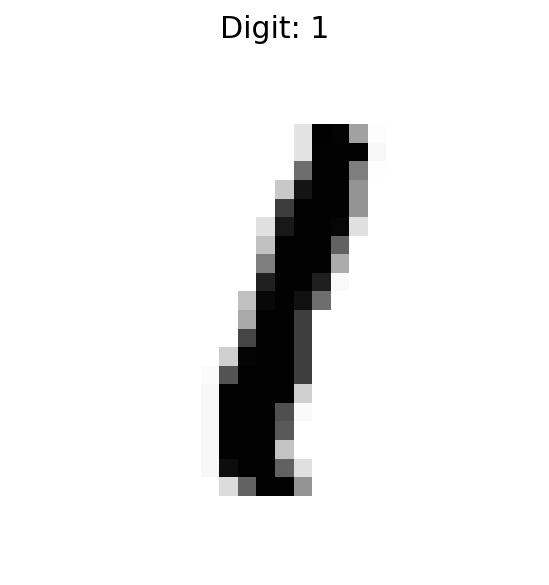

In [10]:
plot_digit(X_train, y_train_oh)

## Convolution

To demonstrate the effect of a convolution we are going to apply simple vertical and horizontal filters to the digits.

In [11]:
kernel_v = np.zeros((3, 3))
kernel_v[:, 0] = -1.
kernel_v[:, 2] = 1.

kernel_h = np.zeros((3, 3))
kernel_h[0, :] = -1.
kernel_h[2, :] = 1.

In [12]:
def plot_kernel(kernel):
    fig, ax = plt.subplots()
    w, h = kernel.shape
    N_levels = int(kernel.max()-kernel.min()+1)
    cmap = plt.get_cmap("coolwarm", N_levels)
    plot = ax.imshow(kernel, cmap=cmap)
    for ix in range(w-1):
        ax.axvline(ix+0.5, c="black", lw=1)
    for iy in range(h-1):
        ax.axhline(iy+0.5, c="black", lw=1)
    cbar = plt.colorbar(plot, ax=ax)
    cbar.set_ticks(np.arange(kernel.min(), kernel.max()+1, 1))
    ax.axis("off")
    fig.tight_layout()

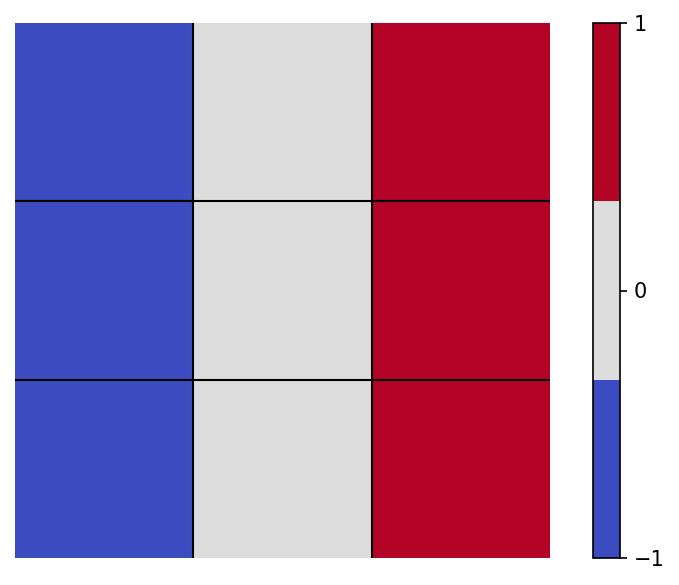

In [13]:
plot_kernel(kernel_v)

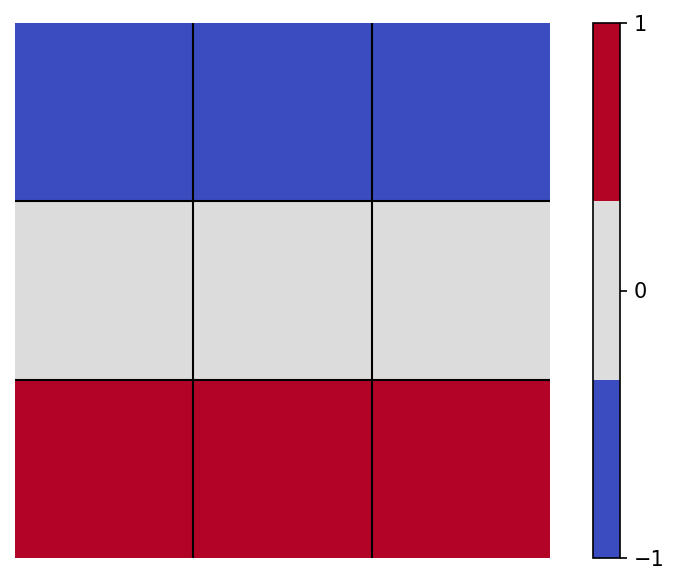

In [14]:
plot_kernel(kernel_h)

We are going to pad the initial digits with zeros at the border to conserve the initial resolution.

In [15]:
def convolve_manual(image, kernel, pad=True):
    kern_h, kern_w = kernel.shape
    img_h, img_w = image.shape
    if ~kern_h%2 or ~kern_w%2:
        raise ValueError("Kernel width and height need to be odd.")
    pad_h, pad_w = int((kern_h-1)/2), int((kern_w-1)/2)
    if pad:
        res_shape = image.shape
        img = np.zeros((img_h+2*pad_h, img_w+2*pad_w))
        img[pad_h:-pad_h, pad_w:-pad_w] = image
    else:
        res_shape = (img_h-2*pad_h, img_w-2*pad_w)
        img = image
    result = np.empty(res_shape)
    for ix in range(result.shape[0]):
        for iy in range(result.shape[1]):
            view = img[ix:ix+2*pad_h+1, iy:iy+2*pad_w+1]
            result[ix, iy] = (view*kernel).sum()
    return result

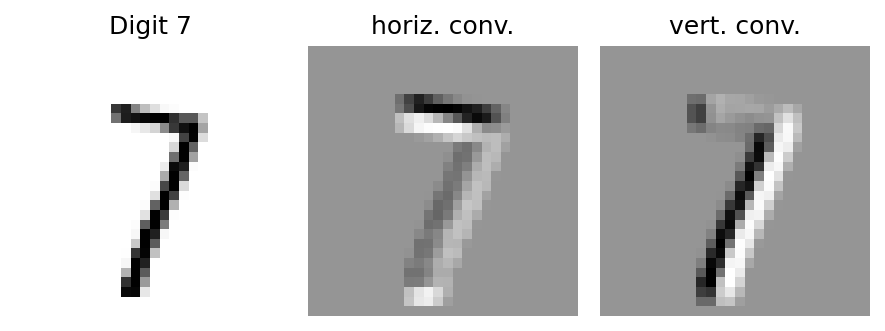

In [16]:
i=42
image = X_train[i, 0, :]
conv1 = convolve_manual(image, kernel_h, pad=True)
conv2 = convolve_manual(image, kernel_v, pad=True)
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(image, cmap="Greys")
ax[0].axis("off")
ax[0].set_title(f"Digit {y_train[i]}")
ax[1].imshow(conv1, cmap="Greys")
ax[1].axis("off")
ax[1].set_title("horiz. conv.")
ax[2].imshow(conv2, cmap="Greys")
ax[2].axis("off")
ax[2].set_title("vert. conv.")
fig.tight_layout()

## Convolution with PyTorch

Here we are doing the sameoperation, but with PyTorch to demonstrate the usage.

In [17]:
import torch

In [18]:
def convolve_torch(image, kernel, pad=True):
    kern_h, kern_w = kernel.shape
    if ~kern_h%2 or ~kern_w%2:
        raise ValueError("Kernel width and height need to be odd.")
    pad_h, pad_w = int((kern_h-1)/2), int((kern_w-1)/2)
    
    if pad:
        padding = (pad_h, pad_w)
    else:
        padding = 0
    
    conv = torch.nn.Conv2d(
        in_channels=1,
        out_channels=1,
        kernel_size=kernel.shape,
        stride=1,
        padding=padding,
        padding_mode="zeros",
        bias=False
    )
    with torch.no_grad():
        conv.weight = torch.nn.Parameter(torch.Tensor(kernel[None, None, ...]))

    return conv(torch.Tensor(image[None, ...])).squeeze().detach().numpy()

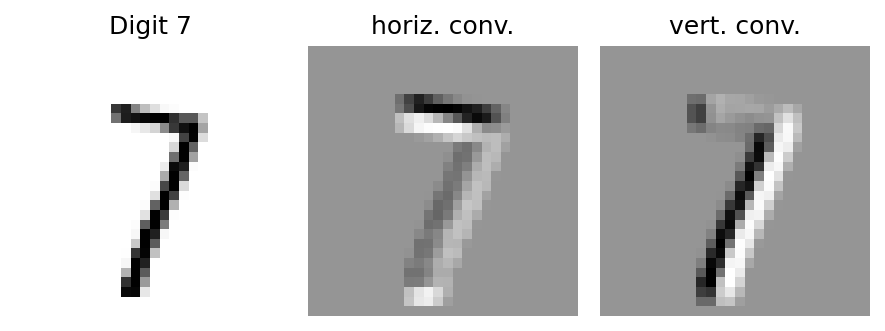

In [19]:
i=42
image = X_train[i, 0, :]
conv1 = convolve_torch(image, kernel_h, pad=True)
conv2 = convolve_torch(image, kernel_v, pad=True)
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(image, cmap="Greys")
ax[0].axis("off")
ax[0].set_title(f"Digit {y_train[i]}")
ax[1].imshow(conv1, cmap="Greys")
ax[1].axis("off")
ax[1].set_title("horiz. conv.")
ax[2].imshow(conv2, cmap="Greys")
ax[2].axis("off")
ax[2].set_title("vert. conv.")
fig.tight_layout()

## Neural network

Now we are going to design a convolutional neural network to identify handwritten digits for us, that simply has one kernel per digit.

In [20]:
class CNN(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.model = torch.nn.Sequential(                                                          # (batch_size,  1, 28, 28) <- Input
            torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=X.shape[-1], bias=False),  # (batch_size, 10,  1,  1)
            torch.nn.Flatten(),                                                                    # (batch_size, 10)         <- Output
        )
        
    def forward(self, x):        
        return self.model(x)
    
    @torch.no_grad()
    def probability(self, x):
        self.eval()
        softmax = torch.nn.Softmax(dim=1)
        return softmax(self.model(x))

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [22]:
cnn = CNN().to(device)

In [23]:
X_train    = torch.Tensor(X_train).to(device)
y_train_oh = torch.Tensor(y_train_oh).to(device)
X_test     = torch.Tensor(X_test).to(device)
y_test_oh  = torch.Tensor(y_test_oh).to(device)

In [24]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [25]:
batch_size = 1_000

In [26]:
dataloader = {}
_ = TensorDataset(X_train, y_train_oh)
dataloader["train"] = DataLoader(_, batch_size=batch_size, shuffle=True)
_ = TensorDataset(X_test, y_test_oh)
dataloader["test"] = DataLoader(_, batch_size=len(X_test), shuffle=False)

In [27]:
import copy
from tqdm.auto import tqdm

In [28]:
def fit(net, dataloader, optimizer, scheduler, criterion, max_epochs):

    train_loss = []
    test_loss  = []
    best_loss = np.inf
    best_net = copy.deepcopy(net)

    pbar = tqdm(range(max_epochs), desc="Train Loss: N/A | Test Loss: N/A | Best Loss: N/A | Epochs")
    for e in pbar:

        tr_loss = 0.
        te_loss = 0.

        datalen = len(dataloader["train"])
        
        net.train()
        for i, (data, target) in enumerate(dataloader["train"]):
            optimizer.zero_grad()
            model = net(data)
            loss = criterion(model, target)
            loss.backward()
            optimizer.step()
            scheduler.step(e + i/datalen)
            tr_loss += loss.item()

        net.eval()
        for data, target in dataloader["test"]:
            model = net(data)
            loss = criterion(model, target)
            te_loss += loss.item()

        train_loss.append(tr_loss/len(dataloader["train"]))
        test_loss.append(te_loss/len(dataloader["test"]))
        
        if test_loss[-1] < best_loss:
            best_net = copy.deepcopy(net)
            best_loss = test_loss[-1]
        
        pbar.set_description("Train Loss: {:1.3e} | Test Loss: {:1.3e} | Best Loss: {:1.3e} | Epochs".format(train_loss[-1], test_loss[-1], best_loss))
        
    loss = {
        "train": train_loss,
        "test": test_loss
    }
        
    return best_net, loss

In [29]:
learning_rate = 1.e-1
weight_decay = 1.e-2
p_drop = 0.03
max_epochs = 250

In [30]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, T_mult=2)

In [31]:
cnn, loss = fit(cnn, dataloader, optimizer, scheduler, criterion, max_epochs)

Train Loss: N/A | Test Loss: N/A | Best Loss: N/A | Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

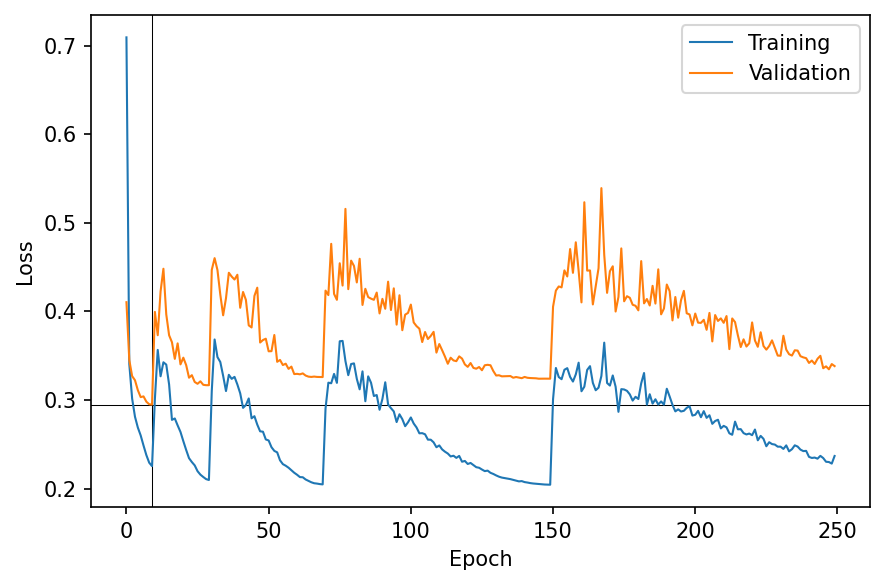

In [32]:
fig, ax = plt.subplots()
ax.axhline(np.min(loss["test"]), lw=0.5, c="black")
ax.axvline(np.argmin(loss["test"]), lw=0.5, c="black")
ax.plot(loss["train"], label="Training", lw=1)
ax.plot(loss["test"], label="Validation", lw=1)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
fig.tight_layout()

In [33]:
filters = cnn.state_dict()["model.0.weight"]

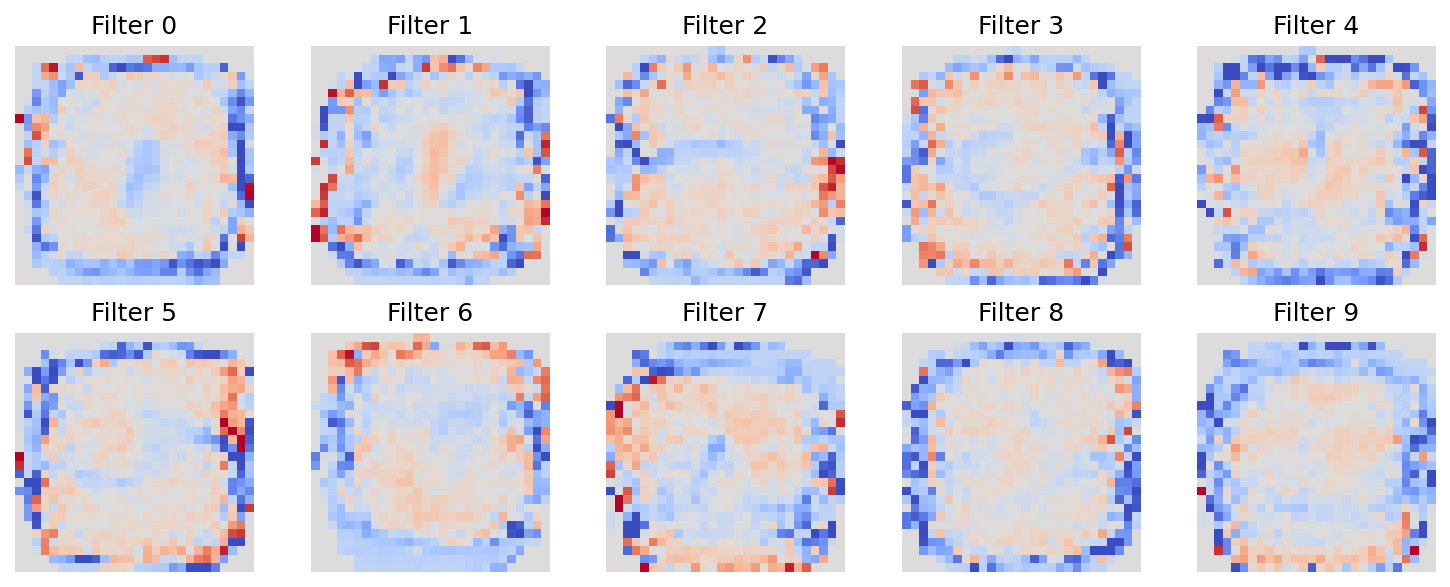

In [34]:
width = 2.
height = width
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(5*width, 2*height))
for i in range(10):
    ix, iy = np.divmod(i, 5)
    ax[ix, iy].axis("off")
    f = 0.5
    ax[ix, iy].imshow(filters[i, 0, ...].cpu().detach().numpy(), cmap="coolwarm", vmin=-f*torch.abs(filters).max(), vmax=f*torch.abs(filters).max())
    ax[ix, iy].set_title(f"Filter {i}")
fig.tight_layout()

In [35]:
def plot_prob(X, y, pred, i=None):
    width = 3.
    height = width/1.6
    if i is None:
        i = np.random.randint(0, len(X)-1)
    d = int(X[0].shape[-1])
    fig = plt.figure(figsize=(3.*width, height))
    ax1 = plt.subplot2grid(shape=(1, 3), loc=(0, 0), colspan=1)
    ax2 = plt.subplot2grid(shape=(1, 3), loc=(0, 1), colspan=2)
    ax1.imshow(X[i, :].reshape((d, d)).cpu(), cmap="Greys", vmax=X.max(), vmin=X.min())
    ax1.axis("off")
    ax1.set_title("Digit: {}".format(y[i]))
    ax2.bar(np.arange(10), pred[i, :]/pred[i, :].sum()*100)
    ax2.set_xlabel("Digit")
    ax2.set_ylabel("Probability")
    ax2.set_ylim(0., 100)
    ax2.grid(axis="y")
    ax2.set_xticks(np.arange(10))
    ax2.set_title("Prediction: {}".format(pred[i].argmax()))
    ax2.set_yticks(ax2.get_yticks())
    ax2.set_yticklabels(["{:3.0f}%".format(p) for p in ax2.get_yticks()])
    fig.tight_layout()

In [36]:
pred_train = cnn.probability(X_train).cpu().detach().numpy()
pred_test  = cnn.probability(X_test).cpu().detach().numpy()

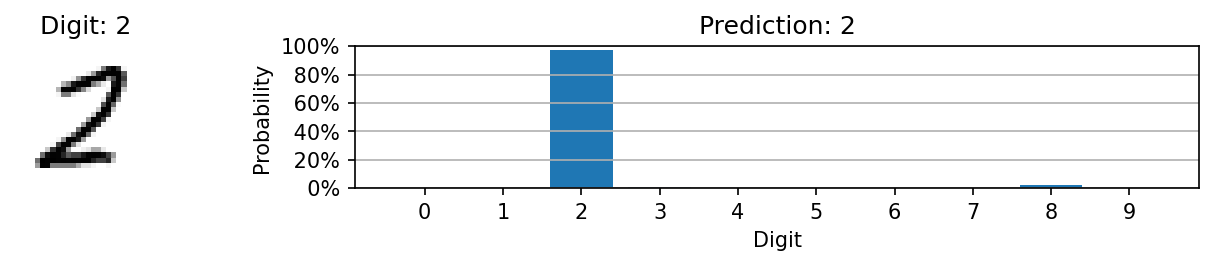

In [37]:
plot_prob(X_test, y_test, pred_test)

In [38]:
mask_fail = y_test != pred_test.argmax(1)

In [39]:
msg = "Total number of false identifications: {}".format(mask_fail.sum())
print(msg)

Total number of false identifications: 931


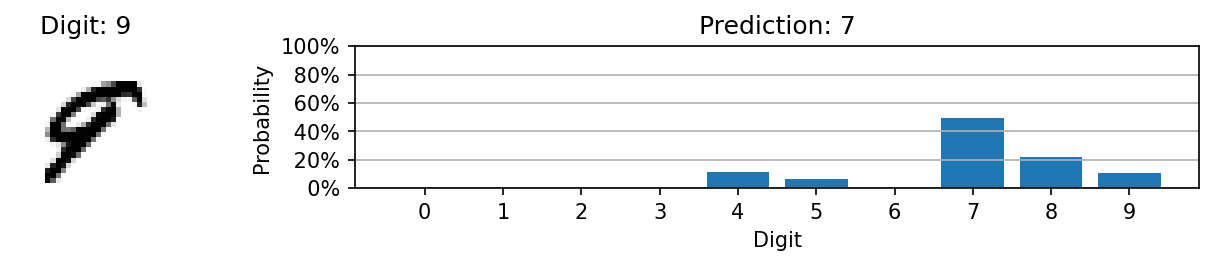

In [40]:
plot_prob(X_test[mask_fail], y_test[mask_fail], pred_test[mask_fail])

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
cmat_test = confusion_matrix(y_test, pred_test.argmax(1), normalize="pred")

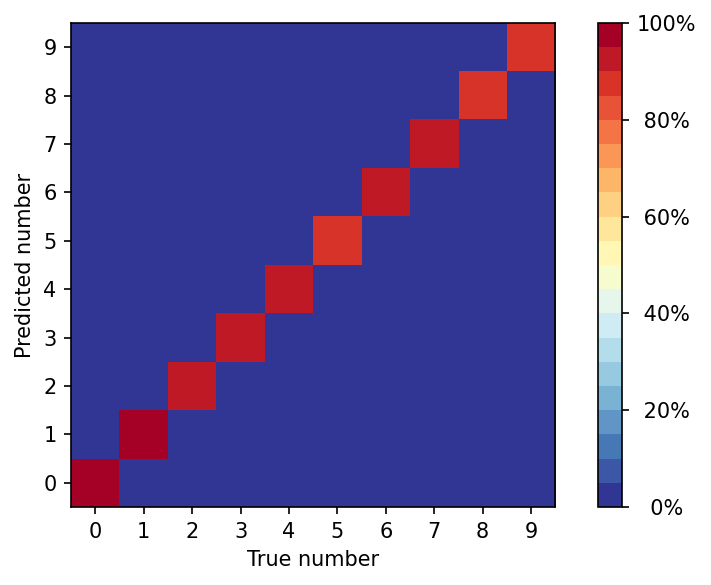

In [43]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("RdYlBu_r", 20)
plot = ax.imshow(cmat_test*100, cmap=cmap, vmin=0, vmax=100)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(["{:3.0f}%".format(proc) for proc in cbar.ax.get_yticks()])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("True number")
ax.set_ylabel("Predicted number")
fig.tight_layout()

In [44]:
acc_train = (y_train == pred_train.argmax(1)).sum()/len(y_train)
acc_test = (y_test == pred_test.argmax(1)).sum()/len(y_test)

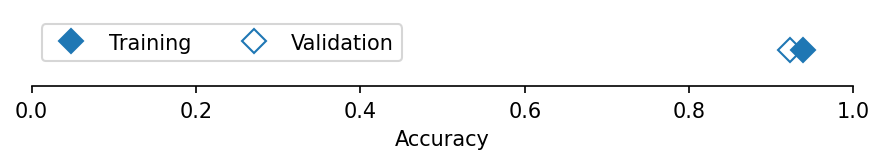

In [45]:
fig, ax = plt.subplots(figsize=(6., 1.2))
ax.plot(acc_train, 0, "D", markersize=8, fillstyle="full", c="C0", label="Training")
ax.plot(acc_test, 0, "D", markersize=8, fillstyle="none", c="C0", label="Validation")
ax.set_xlim(0., 1.)
ax.set_ylim(-0.1, 0.1)
ax.set_xlabel("Accuracy")
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks([])
ax.legend(loc="upper left", ncol=2)
fig.tight_layout()

Repeating the same excercise but with more layers.

In [46]:
class CNN2(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.model = torch.nn.Sequential(                     # (batch_size,  1, 28, 28) <- Input
            torch.nn.Conv2d(1, 32, kernel_size=5),            # (batch_size, 32, 24, 24)
            torch.nn.MaxPool2d(2),                            # (batch_size, 32, 12, 12)
            torch.nn.SELU(inplace=True),
            torch.nn.AlphaDropout(p=p_drop, inplace=True),
            torch.nn.Conv2d(32, 64, kernel_size=3),           # (batch_size, 64, 10, 10)
            torch.nn.MaxPool2d(2),                            # (batch_size, 64,  5,  5)
            torch.nn.SELU(inplace=True),
            torch.nn.AlphaDropout(p=p_drop, inplace=True),
            torch.nn.Flatten(),                               # (batch_size, 64*5*5) = (batch_size, 1600)
            torch.nn.Linear(1600, 10)                         # (batch_size, 10)         <- output
        )
        
    def forward(self, x):
        z = self.model(x)
        return z
    
    @torch.no_grad()
    def probability(self, x):
        self.eval()
        softmax = torch.nn.Softmax(dim=1)
        return softmax(self.model(x))

In [47]:
cnn2 = CNN2().to(device)

In [48]:
learning_rate = 1.e-1
weight_decay = 1.e-2
max_epochs = 250

In [49]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn2.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, T_mult=2)

In [50]:
cnn2, loss2 = fit(cnn2, dataloader, optimizer, scheduler, criterion, max_epochs)

Train Loss: N/A | Test Loss: N/A | Best Loss: N/A | Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

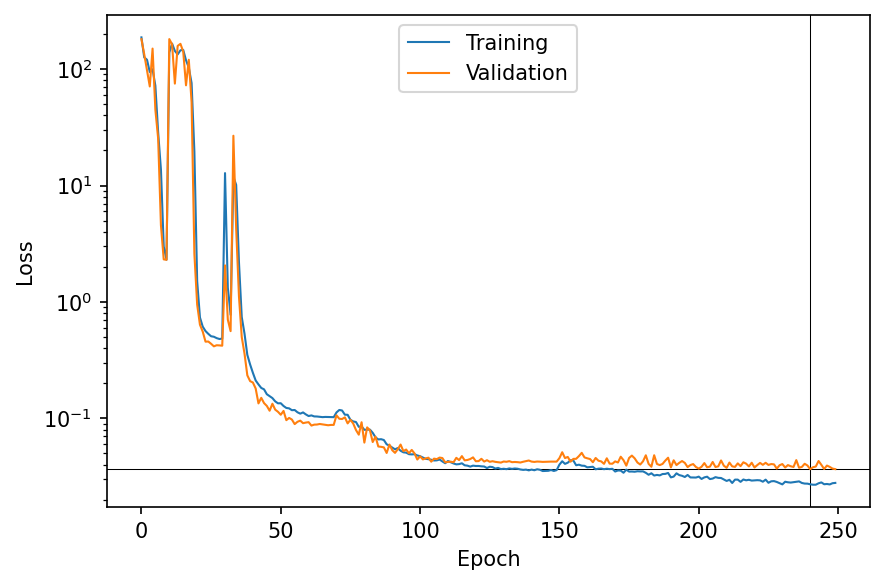

In [51]:
fig, ax = plt.subplots()
ax.axhline(np.min(loss2["test"]), lw=0.5, c="black")
ax.axvline(np.argmin(loss2["test"]), lw=0.5, c="black")
ax.plot(loss2["train"], label="Training", lw=1)
ax.plot(loss2["test"], label="Validation", lw=1)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.legend()
fig.tight_layout()

In [52]:
pred_train2 = cnn2.probability(X_train).cpu().detach().numpy()
pred_test2  = cnn2.probability(X_test).cpu().detach().numpy()

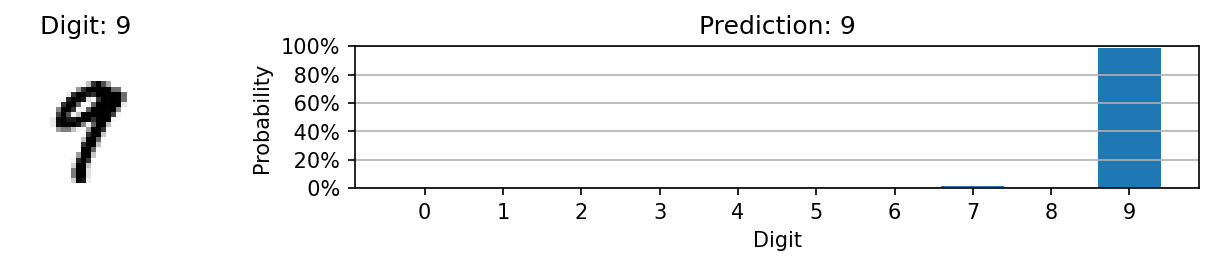

In [53]:
plot_prob(X_test, y_test, pred_test)

In [54]:
mask_fail2 = y_test != pred_test2.argmax(1)

In [55]:
msg = "Total number of false identifications: {}".format(mask_fail2.sum())
print(msg)

Total number of false identifications: 132


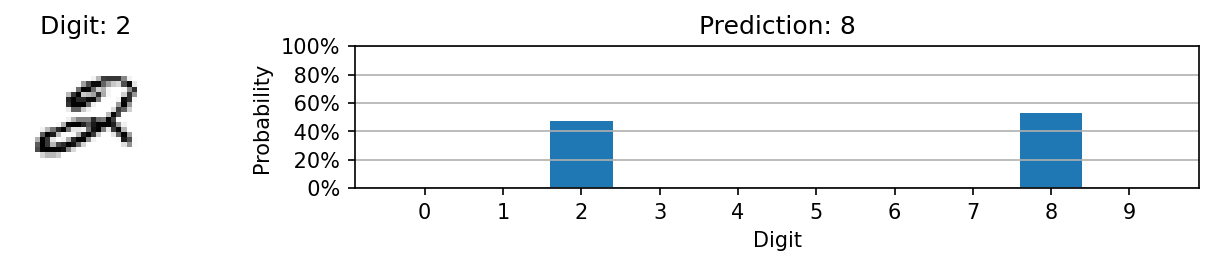

In [56]:
plot_prob(X_test[mask_fail2], y_test[mask_fail2], pred_test2[mask_fail2])

In [57]:
cmat_test2 = confusion_matrix(y_test, pred_test2.argmax(1), normalize="pred")

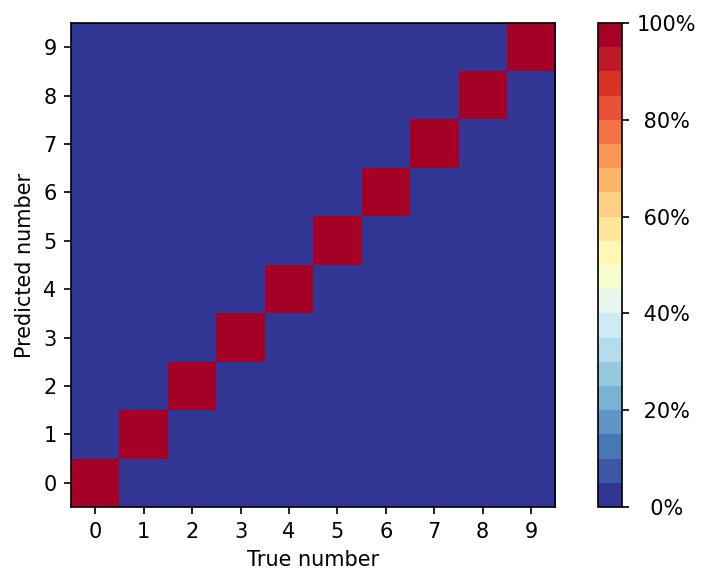

In [58]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("RdYlBu_r", 20)
plot = ax.imshow(cmat_test2*100, cmap=cmap, vmin=0, vmax=100)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(["{:3.0f}%".format(proc) for proc in cbar.ax.get_yticks()])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("True number")
ax.set_ylabel("Predicted number")
fig.tight_layout()

## Accuracy

In [59]:
acc_train2 = (y_train == pred_train2.argmax(1)).sum()/len(y_train)
acc_test2 = (y_test == pred_test2.argmax(1)).sum()/len(y_test)

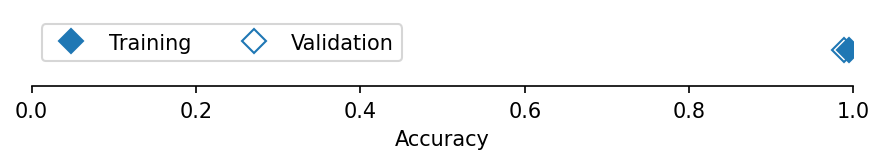

In [60]:
fig, ax = plt.subplots(figsize=(6., 1.2))
ax.plot(acc_train2, 0, "D", markersize=8, fillstyle="full", c="C0", label="Training")
ax.plot(acc_test2, 0, "D", markersize=8, fillstyle="none", c="C0", label="Validation")
ax.set_xlim(0., 1.)
ax.set_ylim(-0.1, 0.1)
ax.set_xlabel("Accuracy")
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks([])
ax.legend(loc="upper left", ncol=2)
fig.tight_layout()